<a href="https://colab.research.google.com/github/JoDeMiro/TimeSeriesLearn/blob/main/10_TSLearn_KNeighbors_TimeSeries_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Hyper-parameter tuning of a Pipeline with KNeighborsTimeSeriesClassifier

In this example, we demonstrate how it is possible to use the different
algorithms of tslearn in combination with sklearn utilities, such as
the `sklearn.pipeline.Pipeline` and `sklearn.model_selection.GridSearchCV`.
In this specific example, we will tune two of the hyper-parameters
of a `KNeighborsTimeSeriesClassifier`.


In [1]:
!pip install -q tslearn

     |████████████████████████████████| 793 kB 8.3 MB/s 


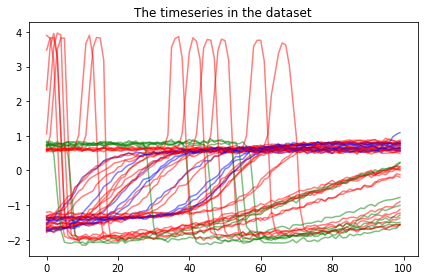

Performing hyper-parameter tuning of KNN classifier... Done!

Got the following accuracies on the test set for each fold:
|n_neighbors |  weights   |score_fold_1|score_fold_2|score_fold_3|
-----------------------------------------------------------------
|           5|     uniform|     0.64706|     0.82353|      0.6875|
|           5|    distance|     0.70588|     0.88235|      0.8125|
|          25|     uniform|     0.64706|     0.64706|       0.625|
|          25|    distance|     0.82353|     0.76471|      0.8125|

Best parameter combination:
weights=distance, n_neighbors=5


In [2]:
# Author: Gilles Vandewiele
# License: BSD 3 clause

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.datasets import CachedDatasets

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import numpy as np

import matplotlib.pyplot as plt

# Our pipeline consists of two phases. First, data will be normalized using
# min-max normalization. Afterwards, it is fed to a KNN classifier. For the
# KNN classifier, we tune the n_neighbors and weights hyper-parameters.
n_splits = 3
pipeline = GridSearchCV(
    Pipeline([
            ('normalize', TimeSeriesScalerMinMax()),
            ('knn', KNeighborsTimeSeriesClassifier())
    ]),
    {'knn__n_neighbors': [5, 25], 'knn__weights': ['uniform', 'distance']},
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)

X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

# Keep only timeseries of class 1, 2, 3
X_train = X_train[y_train > 0]
y_train = y_train[y_train > 0]

# Keep only the first 50 timeseries of both train and
# retain only a small amount of each of the timeseries
X_train, y_train = X_train[:50, 50:150], y_train[:50]

# Plot our timeseries
colors = ['g', 'b', 'r']
plt.figure()
for ts, label in zip(X_train, y_train):
    plt.plot(ts, c=colors[label - 2], alpha=0.5)
plt.title('The timeseries in the dataset')
plt.tight_layout()
plt.show()

# Fit our pipeline
print(end='Performing hyper-parameter tuning of KNN classifier... ')
pipeline.fit(X_train, y_train)
results = pipeline.cv_results_

# Print each possible configuration parameter and the out-of-fold accuracies
print('Done!')
print()
print('Got the following accuracies on the test set for each fold:')

header_str = '|'
columns = ['n_neighbors', 'weights']
columns += ['score_fold_{}'.format(i + 1) for i in range(n_splits)]
for col in columns:
    header_str += '{:^12}|'.format(col)
print(header_str)
print('-'*(len(columns) * 13))

for i in range(len(results['params'])):
    s = '|'
    s += '{:>12}|'.format(results['params'][i]['knn__n_neighbors'])
    s += '{:>12}|'.format(results['params'][i]['knn__weights'])
    for k in range(n_splits):
        score = results['split{}_test_score'.format(k)][i]
        score = np.around(score, 5)
        s += '{:>12}|'.format(score)
    print(s.strip())

best_comb = np.argmax(results['mean_test_score'])
best_params = results['params'][best_comb]

print()
print('Best parameter combination:')
print('weights={}, n_neighbors={}'.format(best_params['knn__weights'],
                                          best_params['knn__n_neighbors']))